# HCAHPS Patient Satisfaction Analysis (2014 - 2023)

**Author**: *Hassan Al Nemrawi*  
**Date**: *02/12/2025*

---

## Table of Contents

1. [Executive Summary](#executive-summary)  
2. [Introduction & Context](#introduction-context)  
3. [Data Overview](#data-overview)  
   - 3.1 [Data Dictionary](#data-dictionary)  
   - 3.2 [Data Collection & Quality Checks](#data-collection-and-quality-checks)  
4. [Exploratory Data Analysis (EDA)](#eda)  
   - 4.1 [Boxplots: Bottom/Middle/Top-box](#boxplots)  
   - 4.2 [Yearly Average Top-box Trends](#yearly-trends)  
   - 4.3 [Measure-Level Trends Over Time](#measure-level-trends)  
   - 4.4 [COVID-19 Impact Analysis](#covid-impact)  
   - 4.5 [State-Level Performance](#state-performance)  
5. [Advanced Modeling & Statistical Analysis](#modeling)  
   - 5.1 [Modeling Objective & Approach](#modeling-objective)  
   - 5.2 [Data Preparation & Feature Engineering](#data-prep)  
   - 5.3 [Model Selection & Cross-Validation](#model-selection)  
   - 5.4 [Residual Analysis & Diagnostics](#residual-analysis)  
   - 5.5 [Feature Importance & Interaction Analysis](#feature-importance)  
6. [Findings & Insights](#findings-and-insights)  
7. [Recommendations & Next Steps](#recommendations-and-next-steps)  
8. [References](#references)
---

<a id="executive-summary"></a>
## 1. Executive Summary

Between 2014 and 2023, U.S. hospitals reported patient satisfaction (HCAHPS) scores that consistently hovered around **70–72% (Top-box)**. However, the COVID-19 pandemic caused a notable decline in scores starting in 2021, with an average dip of **2–3%** before a mild recovery in 2023.

Our analysis used **advanced regression models** to identify the following key drivers of the Overall Hospital Rating:
- **Care Transition**
- **Quietness of Hospital Environment**
- **Cleanliness**

Conversely, **Communication about Medicines** remains a challenge, consistently underperforming, especially during the pandemic years.

### Key Insights and Recommendations
- **Targeted Improvements**: Hospitals should focus on care coordination and clearer patient communication to improve patient experience scores.
- **Model Performance**: High-performing models, such as **Lasso Regression**, achieved a predictive accuracy of **R² > 0.93**, supporting these findings and recommendations.

With these insights, hospitals can better allocate resources and enhance patient satisfaction by addressing critical service areas.


---

<a id="introduction-context"></a>
## 2. Introduction & Context
### Why HCAHPS Matters

The **Hospital Consumer Assessment of Healthcare Providers and Systems (HCAHPS)** survey is a standardized tool used to measure patient satisfaction across hospitals in the United States. These results have significant implications:

- **Hospital Reputation & Funding**: HCAHPS scores are directly linked to **Value-Based Purchasing (VBP)** and **Medicare reimbursements**, affecting both financial incentives and institutional reputation.
- **Healthcare Quality Improvements**: By identifying trends in low-scoring measures, healthcare providers can allocate resources more effectively to enhance the **patient experience** and **care quality**.

### **Key Questions**
1. **How have patient satisfaction trends (Top-box) evolved from 2014–2023?**
2. **Which measures most impact the Overall Hospital Rating?**
3. **What impact did COVID-19 have on HCAHPS scores?**
4. **Are there significant performance variations across states and regions?**

---

<a id="data-overview"></a>
## 3. Data Overview

<a id="data-dictionary"></a>
### 3.1 Data Dictionary

| **Column**                           | **Type**     | **Description**                                                                     |
|-------------------------------------|--------------|-------------------------------------------------------------------------------------|
| **Release Period**                  | String       | Quarterly release identifier (e.g., `07_2015`)                                      |
| **State**                           | String       | Two-letter state abbreviation                                                       |
| **Measure ID**                      | String       | Unique measure code (e.g., `H_CLEAN_HSP`)                                          |
| **Bottom-box Percentage**           | Float        | % giving the lowest response tier                                                  |
| **Middle-box Percentage**           | Float        | % giving a mid-tier response                                                       |
| **Top-box Percentage**              | Float        | % giving the highest tier response                                                 |
| **State Name**                      | String       | Full state name                                                                     |
| **Region**                          | String       | Broader region classification (e.g., `East South Central`)                         |
| **Measure**                         | String       | Descriptive measure name (e.g., `Communication with Nurses`)                       |
| **Type**                            | String       | Measure type: `Composite`, `Individual Item`, or `Global`                          |
| **Start Date**                      | DateTime     | Survey start date                                                                  |
| **End Date**                        | DateTime     | Survey end date                                                                    |
| **Year**                            | Integer      | Derived from `End Date`                                                            |
| **Bottom-box Percentage_national**  | Float        | National average of bottom-box responses                                           |
| **Middle-box Percentage_national**  | Float        | National average of middle-box responses                                           |
| **Top-box Percentage_national**     | Float        | National average of top-box responses                                              |


<a id="data-collection-and-quality-checks"></a>
### 3.2 Data Collection & Quality Checks
- Source: CMS HCAHPS data from Hospital Compare (Archived)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from scipy.stats import ttest_ind, ttest_rel

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For modeling and diagnostics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import scipy.stats as stats
import statsmodels.api as sm
import shap

warnings.filterwarnings("ignore")


In [21]:
BASE_DIR = Path.cwd().parent
data_path = BASE_DIR / "data" / "final_merged_dataset.csv"

# Load the dataset with date parsing
hcahps_data = pd.read_csv(data_path, parse_dates=["Start Date", "End Date"])
print("Data loaded. Shape:", hcahps_data.shape)

# Basic dataset overview
hcahps_data.info()
display(hcahps_data.head(5))

# Remove duplicates if any
duplicates = hcahps_data.duplicated().sum()
print("Duplicates found:", duplicates)
if duplicates > 0:
    hcahps_data.drop_duplicates(inplace=True)

# Check for missing values
missing_counts = hcahps_data.isnull().sum()
print("\nMissing Values:\n", missing_counts)

# Validate percentage columns are within [0, 100]
for col in ["Bottom-box Percentage", "Middle-box Percentage", "Top-box Percentage"]:
    if (hcahps_data[col] < 0).any() or (hcahps_data[col] > 100).any():
        print(f"Invalid values found in {col}.")
    else:
        print(f"{col} is within the expected range [0, 100].")

Data loaded. Shape: (5100, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5100 entries, 0 to 5099
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Release Period                  5100 non-null   object        
 1   State                           5100 non-null   object        
 2   Measure ID                      5100 non-null   object        
 3   Bottom-box Percentage           5100 non-null   int64         
 4   Middle-box Percentage           5100 non-null   int64         
 5   Top-box Percentage              5100 non-null   int64         
 6   State Name                      5090 non-null   object        
 7   Region                          5090 non-null   object        
 8   Measure                         5100 non-null   object        
 9   Type                            5100 non-null   object        
 10  Start Date                      5100 non-

,Release Period,State,Measure ID,Bottom-box Percentage,Middle-box Percentage,Top-box Percentage,State Name,Region,Measure,Type,Start Date,End Date,Year,Bottom-box Percentage_national,Middle-box Percentage_national,Top-box Percentage_national
0,07_2015,AK,H_CLEAN_HSP,8,22,70,Alaska,Pacific,Cleanliness of Hospital Environment,Individual Item,2013-10-01,2014-09-30,2014,8,18,74
1,07_2015,AK,H_COMP_1,9,17,74,Alaska,Pacific,Communication with Nurses,Composite Measure,2013-10-01,2014-09-30,2014,4,17,79
2,07_2015,AK,H_COMP_2,10,15,75,Alaska,Pacific,Communication with Doctors,Composite Measure,2013-10-01,2014-09-30,2014,4,14,82
3,07_2015,AK,H_COMP_3,11,21,68,Alaska,Pacific,Responsiveness of Hospital Staff,Composite Measure,2013-10-01,2014-09-30,2014,9,23,68
4,07_2015,AK,H_COMP_5,19,17,64,Alaska,Pacific,Communication about Medicines,Composite Measure,2013-10-01,2014-09-30,2014,18,17,65


Duplicates found: 0

Missing Values:
 Release Period                     0
State                              0
Measure ID                         0
Bottom-box Percentage              0
Middle-box Percentage              0
Top-box Percentage                 0
State Name                        10
Region                            10
Measure                            0
Type                               0
Start Date                         0
End Date                           0
Year                               0
Bottom-box Percentage_national     0
Middle-box Percentage_national     0
Top-box Percentage_national        0
dtype: int64
Bottom-box Percentage is within the expected range [0, 100].
Middle-box Percentage is within the expected range [0, 100].
Top-box Percentage is within the expected range [0, 100].


- No duplicates).
- Very few missing values related to RP State being only available in the 2024 data.
- All **percentage columns** validated in [0–100] range.


---
<a id="eda"></a>
## 4. Exploratory Data Analysis (EDA)

In [22]:
print("Descriptive Statistics:")
display(hcahps_data.describe(include='all').T)

Descriptive Statistics:


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Release Period,5100,10,07_2024,520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
State,5100,52,AK,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Measure ID,5100,10,H_CLEAN_HSP,510,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bottom-box Percentage,5100.0,NaN,NaN,NaN,8.481765,2.0,5.0,7.0,11.0,35.0,4.656621
Middle-box Percentage,5100.0,NaN,NaN,NaN,20.332353,0.0,16.0,19.0,25.0,49.0,10.500475
Top-box Percentage,5100.0,NaN,NaN,NaN,71.185882,42.0,65.0,72.0,79.0,91.0,10.376061
State Name,5090,51,Alaska,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Region,5090,9,South Atlantic,890,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Measure,5100,10,Cleanliness of Hospital Environment,510,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,5100,3,Composite Measure,3060,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Numerical Columns:**
* Bottom-box Percentage: Mean of 8.47%, with a standard deviation of 4.63%. The range is from 2% to 29%.
* Middle-box Percentage: Mean of 20.32%, with a standard deviation of 10.50%. The range is from 0% to 49%.
* Top-box Percentage: Mean of 71.21%, with a standard deviation of 10.36%. The range is from 42% to 91%.
* Year: Ranges from 2014 to 2023.

**Categorical Columns:**
* State: 51 unique states.
* Measure: 10 unique measures.
* Type: 3 types of measures (Composite Measure, Individual Item, Global Item).


<a id="boxplots"></a>
### 4.1 Boxplots: Bottom/Middle/Top-box

Below is a figure illustrating the distribution of Bottom-box, Middle-box, and Top-box percentages:

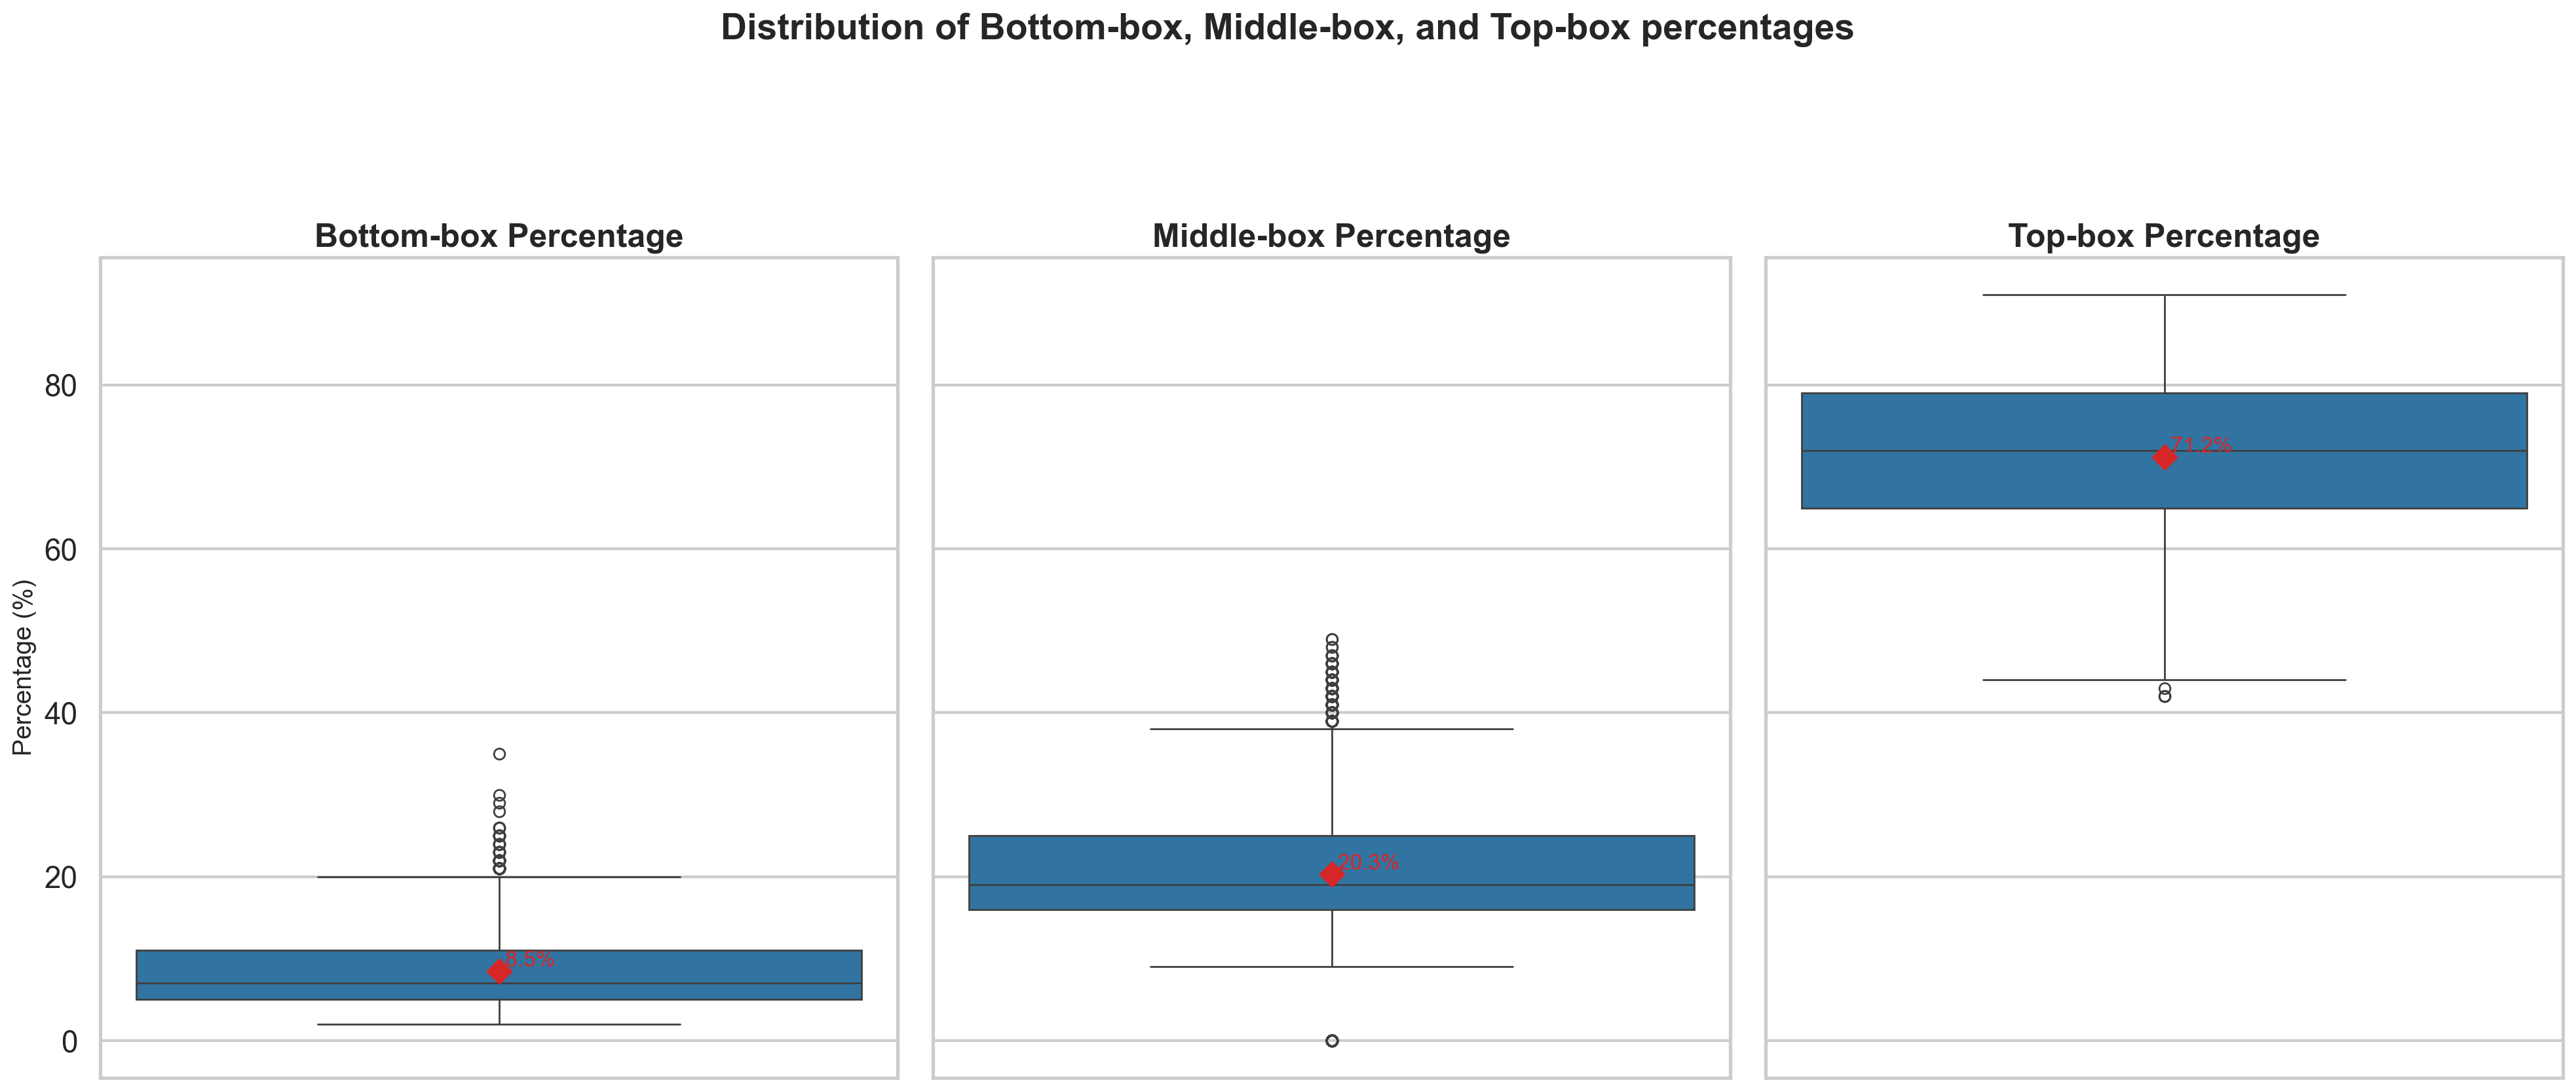

In [23]:
sns.set_theme(style="whitegrid", context="talk", palette="deep")
primary_color = "#1f77b4"
highlight_color = "#d62728"

fig, axes = plt.subplots(1, 3, figsize=(20, 8), sharey=True, dpi=200)
cols = ['Bottom-box Percentage', 'Middle-box Percentage', 'Top-box Percentage']

for ax, col in zip(axes, cols):
    sns.boxplot(data=hcahps_data, y=col, ax=ax, color=primary_color, width=0.5, fliersize=6)
    mean_val = hcahps_data[col].mean()
    ax.scatter(0, mean_val, color=highlight_color, marker='D', s=80, zorder=10)
    ax.text(0, mean_val, f' {mean_val:.1f}%', color=highlight_color, fontsize=12, va='bottom')
    ax.set_title(col, fontsize=18, fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel("Percentage (%)", fontsize=14)

fig.suptitle("Distribution of Bottom-box, Middle-box, and Top-box percentages", fontsize=20, fontweight='bold', y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


- **Bottom-box** median around 8–10%, with some outliers near 30%.  
- **Middle-box** around ~20% on average but can reach 40%+ in outliers.  
- **Top-box** mostly 65–75%, some hospitals/measures go as low as ~40% or as high as 90%.

<a id="yearly-trends"></a>
### 4.2 Yearly Average Top-box Trends


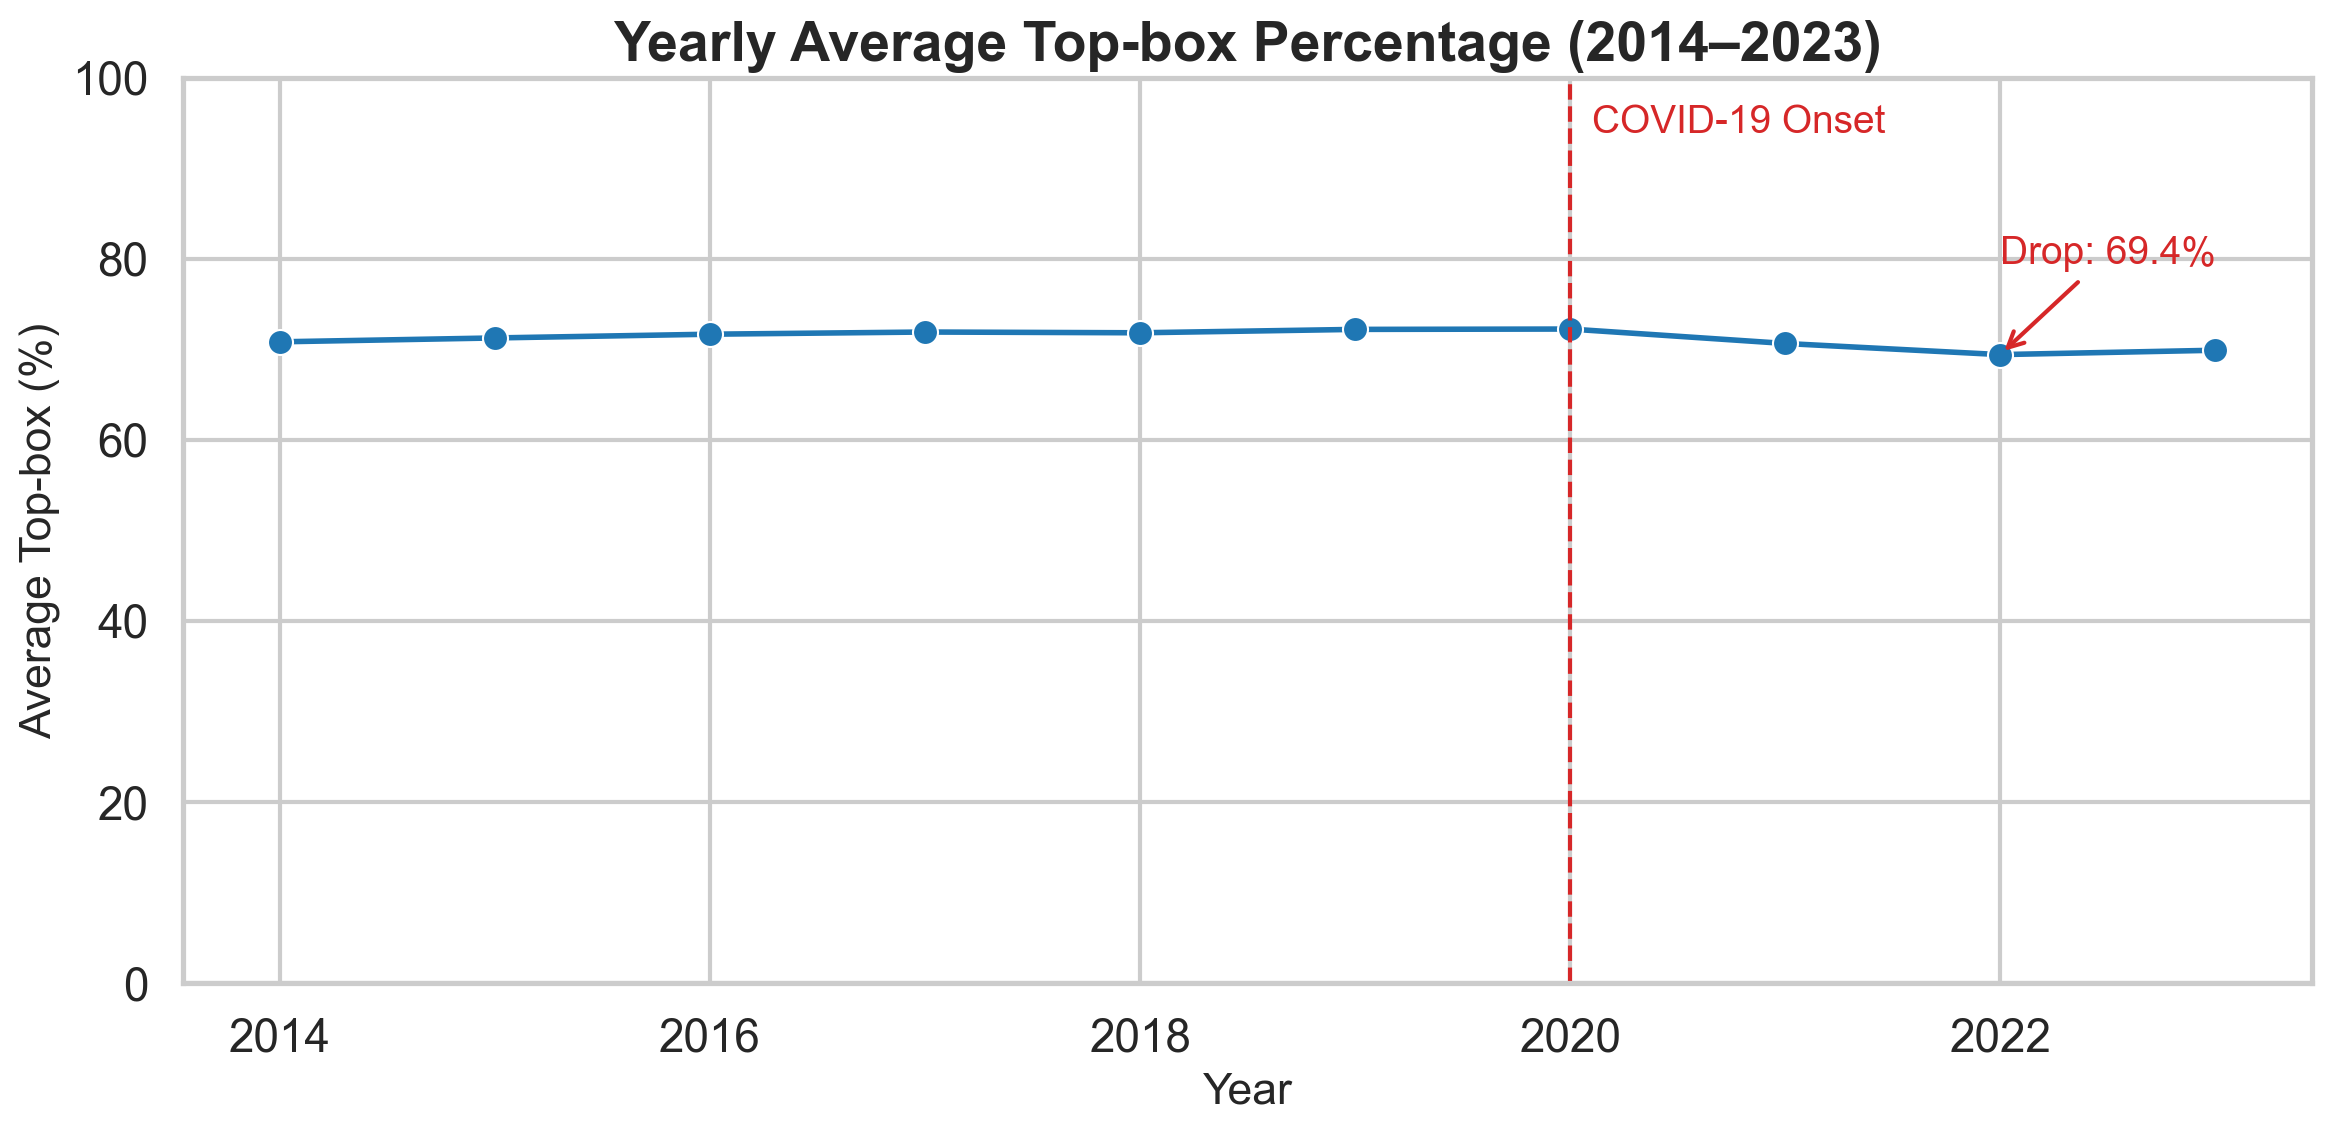

In [24]:
yearly_trend = hcahps_data.groupby("Year")["Top-box Percentage"].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
sns.lineplot(data=yearly_trend, x="Year", y="Top-box Percentage", marker="o", color=primary_color, linewidth=2, ax=ax)

ax.set_title("Yearly Average Top-box Percentage (2014–2023)", fontsize=20, fontweight="bold")
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Average Top-box (%)", fontsize=16)
ax.set_ylim(0, 100)

ax.axvline(x=2020, linestyle="--", color=highlight_color, linewidth=1.5)
ax.text(2020 + 0.1, 95, "COVID-19 Onset", color=highlight_color, fontsize=14, va='center')

dip_val = yearly_trend.loc[yearly_trend['Year'] == 2022, "Top-box Percentage"].values
if dip_val.size:
    ax.annotate(f"Drop: {dip_val[0]:.1f}%", xy=(2022, dip_val[0]), xytext=(2022, dip_val[0] + 10),
                arrowprops=dict(facecolor=highlight_color, arrowstyle="->", color=highlight_color),
                fontsize=14, color=highlight_color)

plt.tight_layout()
plt.show()


**Observation:**
- Stable ~70–72% from 2014–2020.
- Notable dip in 2021–2022 (lowest ~69.4% in 2022) which is likely due to increased healthcare pressures, service disruptions, and resource limitations during the pandemic.
- Partial rebound in 2023 (~70.1%).

<a id="measure-level-trends"></a>
### 4.3 Measure-Level Trends Over Time


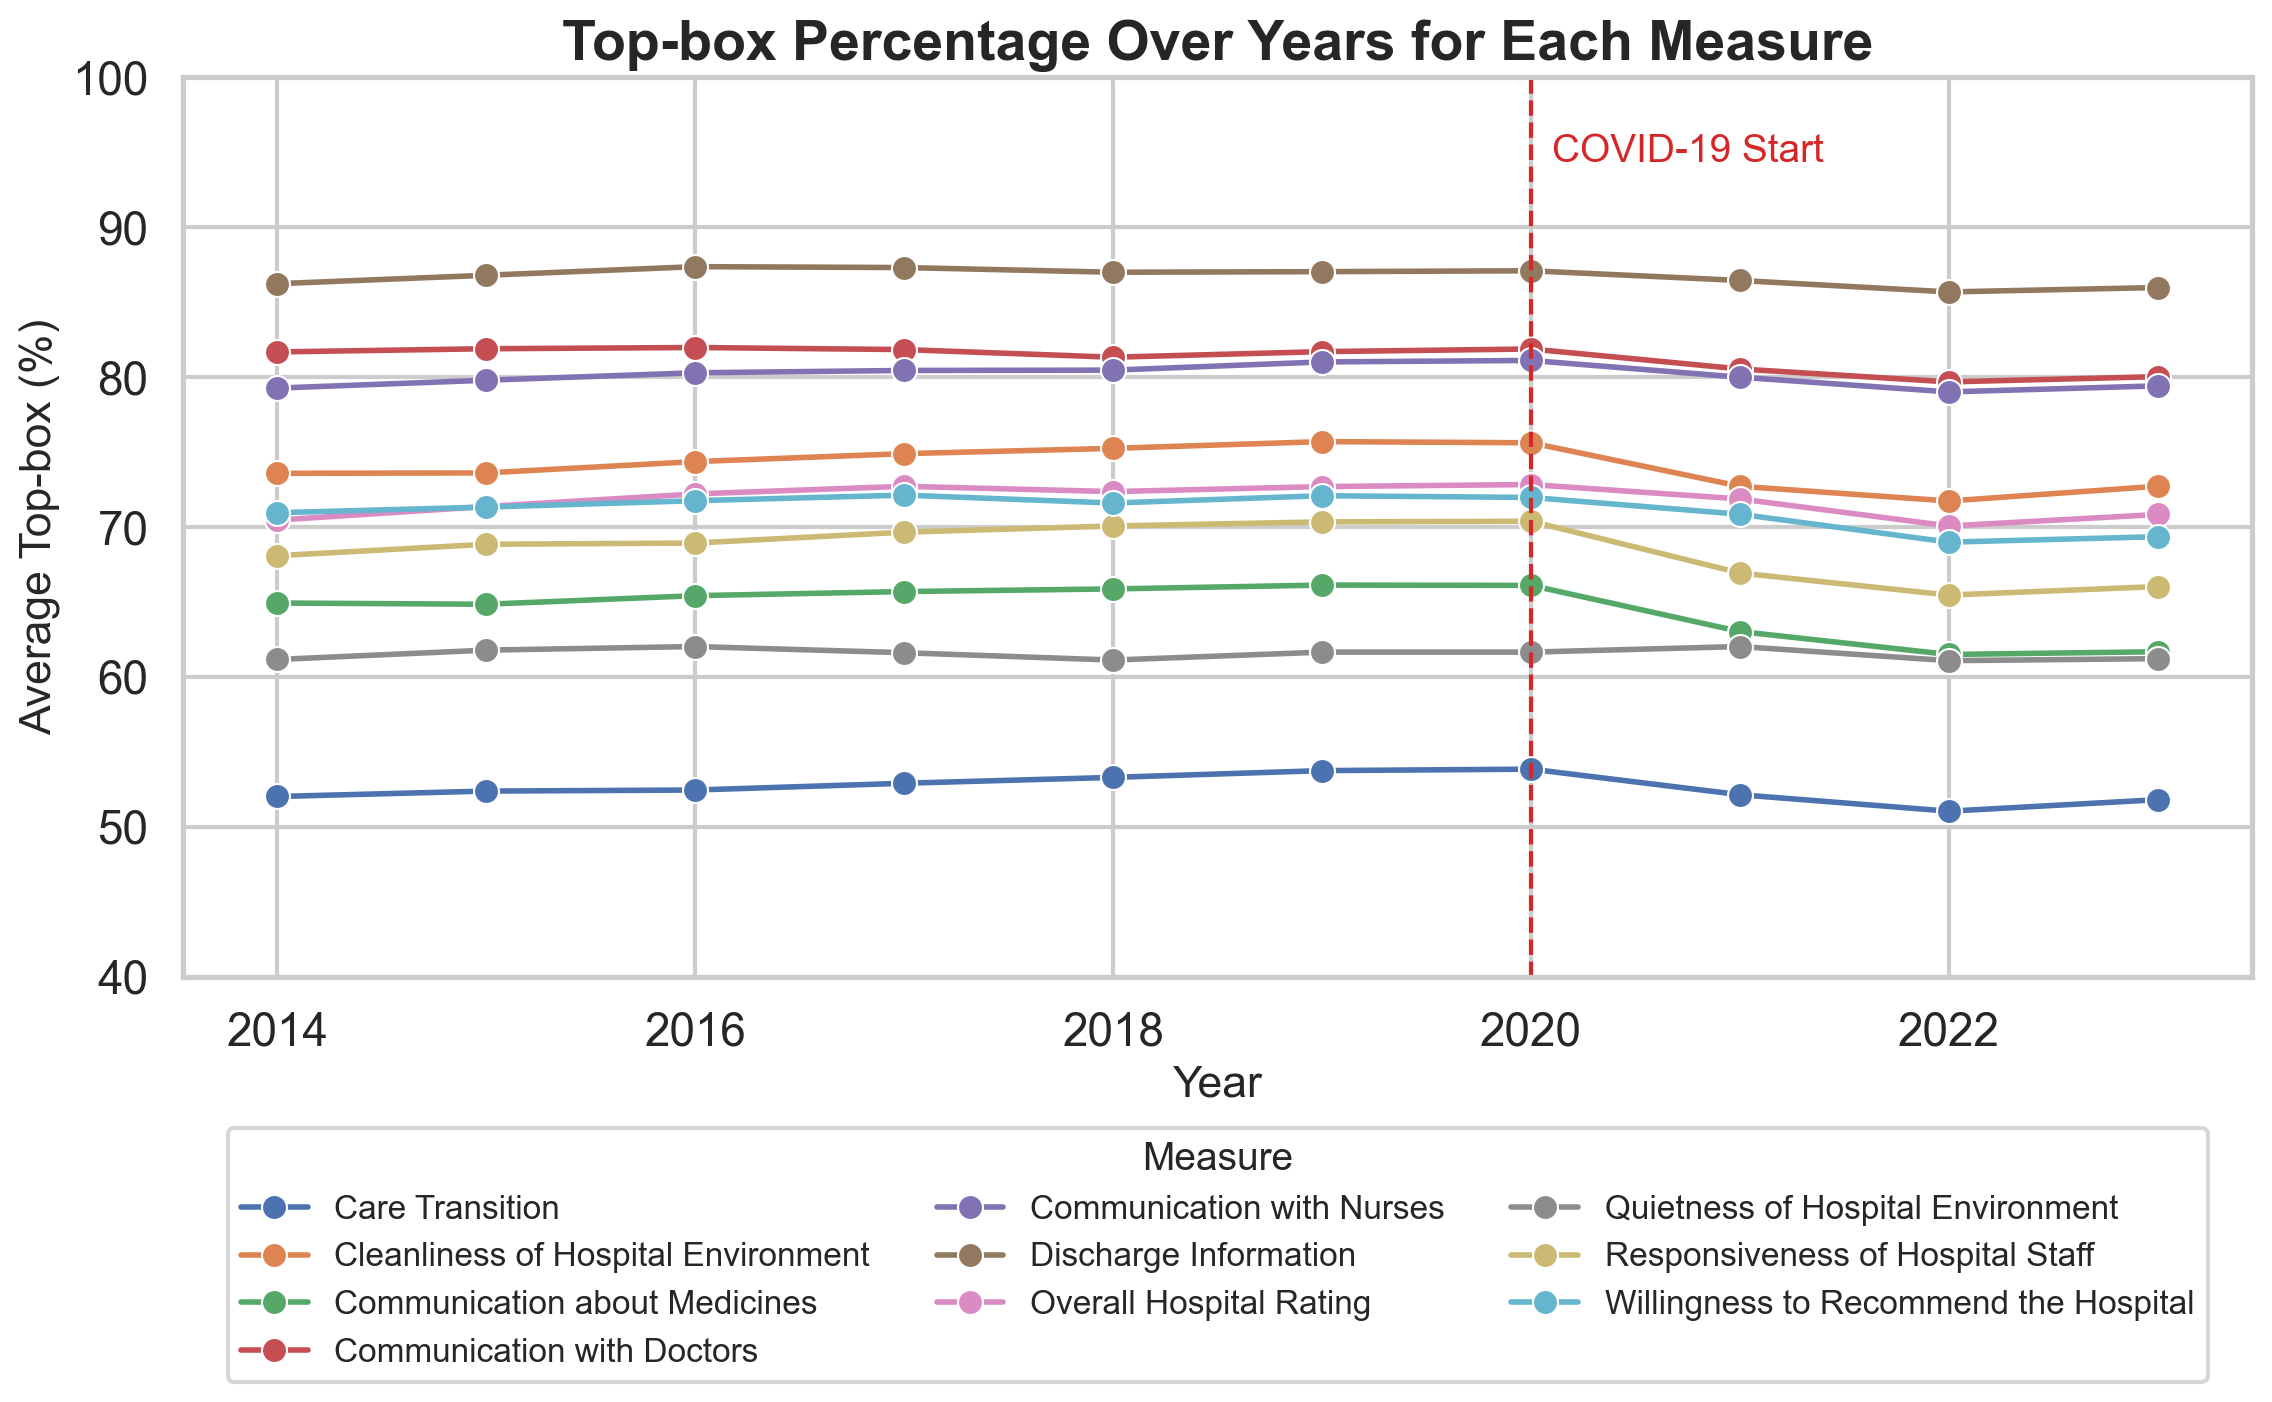

In [25]:
measure_trends = hcahps_data.groupby(["Year", "Measure"])["Top-box Percentage"].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 8), dpi=200)
sns.lineplot(data=measure_trends, x="Year", y="Top-box Percentage", hue="Measure", marker="o", linewidth=2, ax=ax)

ax.set_title("Top-box Percentage Over Years for Each Measure", fontsize=20, fontweight="bold")
ax.set_xlabel("Year", fontsize=16)
ax.set_ylabel("Average Top-box (%)", fontsize=16)
ax.set_ylim(40, 100)

ax.axvline(x=2020, linestyle="--", color=highlight_color, linewidth=1.5)
ax.text(2020 + 0.1, 95, "COVID-19 Start", color=highlight_color, fontsize=14, va='center')

ax.legend(title="Measure", title_fontsize=14, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


- Most measures stayed stable between 2014 and 2020, ranging from 60% to 85%.  
- A noticeable dip, though not drastic, occurred around 2021, impacting measures like **Overall Hospital Rating** and **Communication with Nurses**.  
- The decline aligns with the onset of the COVID-19 pandemic (red vertical line), reflecting its effect on patient experience.  
- Some measures show signs of recovery by 2023, though a few remain below pre-pandemic levels.


<a id="covid-impact"></a>
### 4.4 COVID-19 Impact Analysis

#### 4.4.1 Change in Top-box Percentage Before vs After COVID by Measure


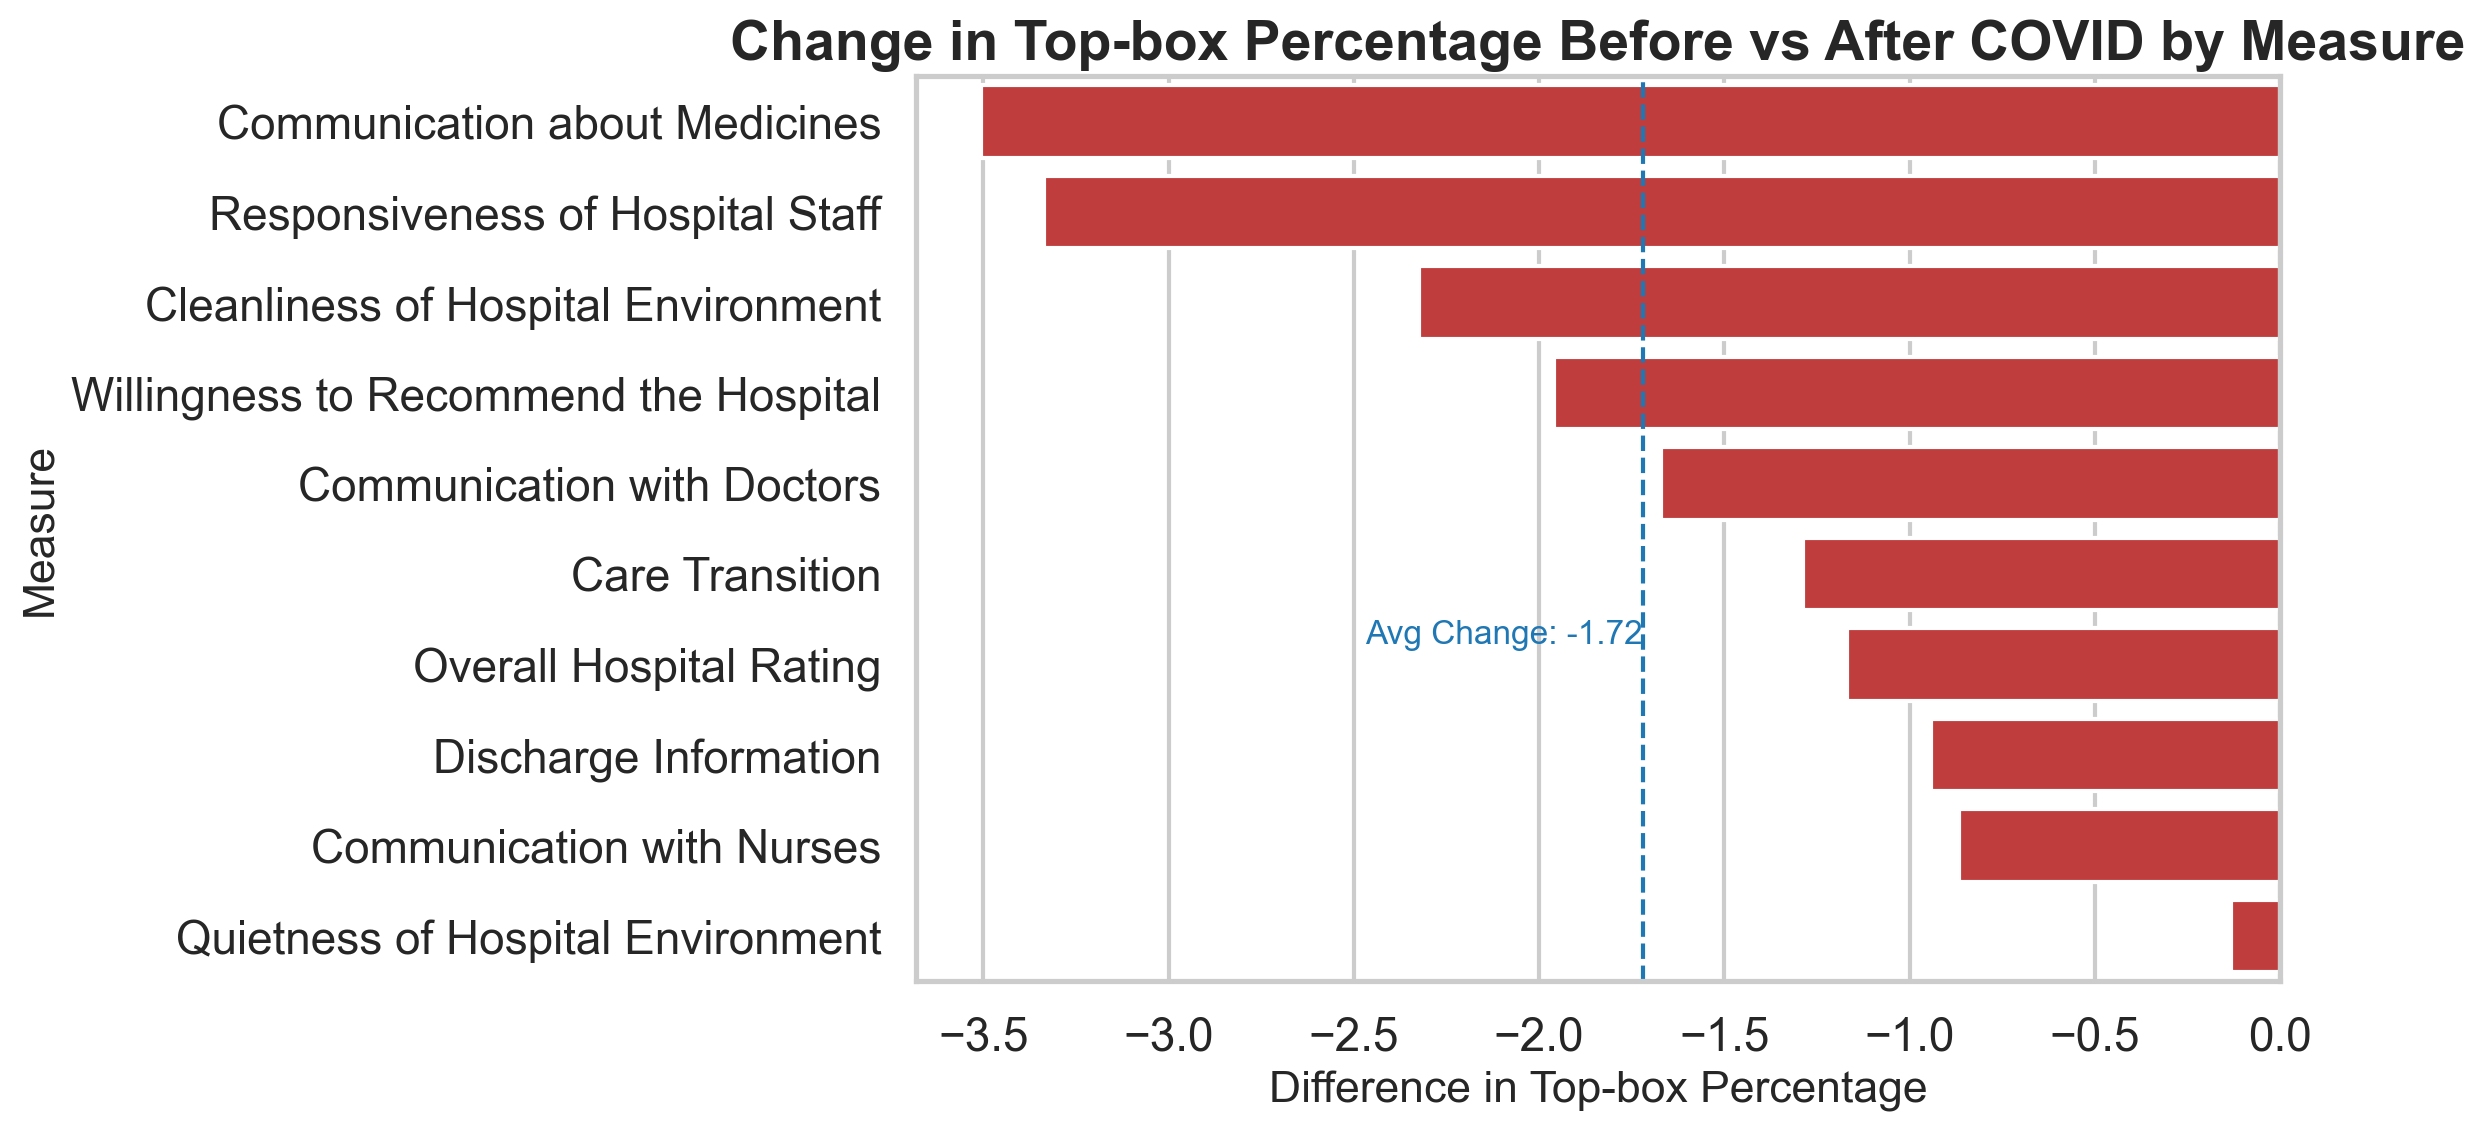

In [26]:
before_covid = hcahps_data[hcahps_data['Year'] < 2021].groupby('Measure')['Top-box Percentage'].mean().reset_index()
after_covid  = hcahps_data[hcahps_data['Year'] >= 2021].groupby('Measure')['Top-box Percentage'].mean().reset_index()

before_after = before_covid.merge(after_covid, on='Measure', suffixes=('_before', '_after'))
before_after['Difference'] = before_after['Top-box Percentage_after'] - before_after['Top-box Percentage_before']
before_after = before_after.sort_values('Difference', ascending=True)

colors = [primary_color if diff >= 0 else highlight_color for diff in before_after['Difference']]

fig, ax = plt.subplots(figsize=(12, 6), dpi=200)
sns.barplot(data=before_after, x="Difference", y="Measure", palette=colors, ax=ax)

avg_change = before_after['Difference'].mean()
ax.axvline(x=avg_change, linestyle="--", color=primary_color, linewidth=1.5)
y_max = ax.get_ylim()[1]
ax.text(avg_change, y_max + 6, f"Avg Change: {avg_change:.2f}", color=primary_color, fontsize=12,
        ha='right', va='top')

ax.set_title("Change in Top-box Percentage Before vs After COVID by Measure", fontsize=20, fontweight="bold")
ax.set_xlabel("Difference in Top-box Percentage", fontsize=16)
ax.set_ylabel("Measure", fontsize=16)

plt.tight_layout()
plt.show()

- All measures saw a decline in top-box scores post-COVID, with an average decrease of **-1.72%**.  
- **Communication about Medicines** and **Responsiveness of Hospital Staff** experienced the largest drops, exceeding **-3%**, likely due to pandemic-induced strains on healthcare systems.  
- Measures like **Quietness of Hospital Environment** showed minimal change, indicating that certain aspects of patient experience were less impacted.  
- The consistent downward trend across most measures highlights the broad impact of the pandemic on healthcare service quality and patient satisfaction.  


#### 4.4.2 Change in Overall Hospital Rating Before vs After COVID-19 by State


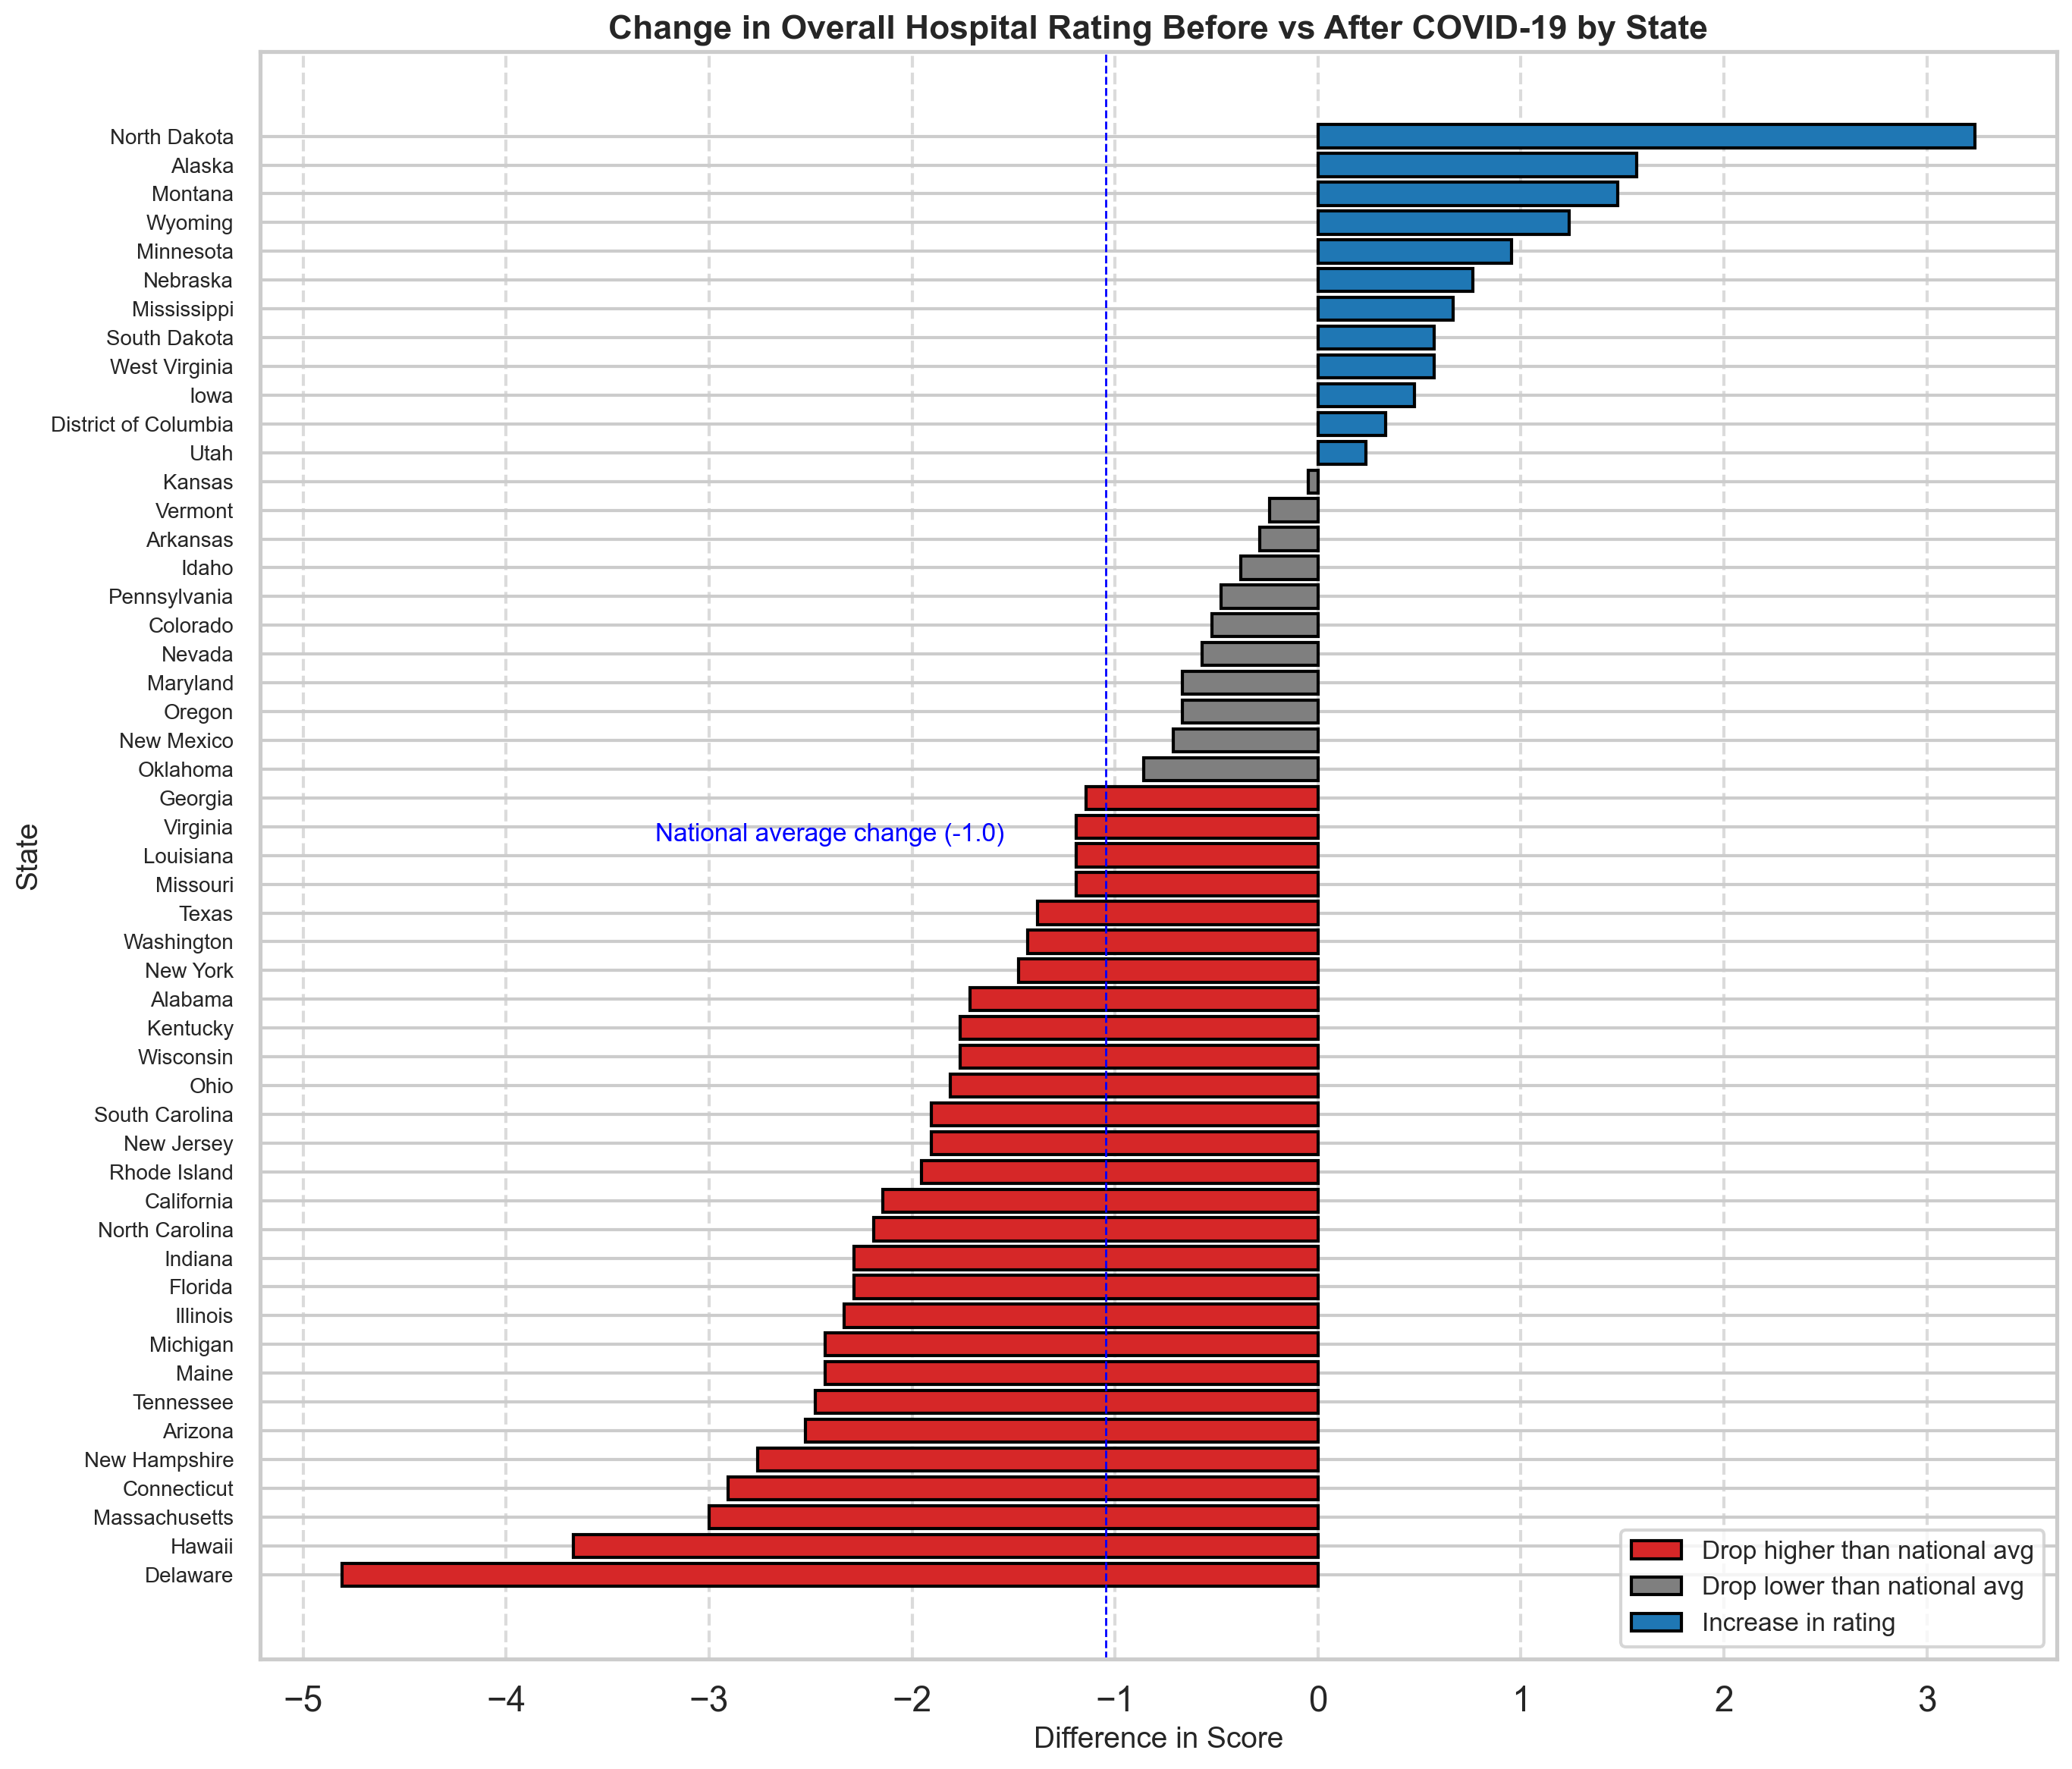

In [27]:
# Define measure and year split
year_split = 2021
measure = 'Overall Hospital Rating'

# Calculate averages for each state before and after COVID-19
before_covid_state = hcahps_data[(hcahps_data['Year'] < year_split) & (hcahps_data['Measure'] == measure)] \
    .groupby('State Name')['Top-box Percentage'].mean().reset_index()
after_covid_state = hcahps_data[(hcahps_data['Year'] >= year_split) & (hcahps_data['Measure'] == measure)] \
    .groupby('State Name')['Top-box Percentage'].mean().reset_index()

# Merge and calculate the difference
before_after_covid_state = before_covid_state.merge(after_covid_state, on='State Name', suffixes=('_before', '_after'))
before_after_covid_state['Difference'] = before_after_covid_state['Top-box Percentage_after'] - before_after_covid_state['Top-box Percentage_before']
before_after_covid_state = before_after_covid_state.sort_values('Difference', ascending=True)

# Calculate national average change
national_avg_change = before_after_covid_state['Difference'].mean()

# Categorize states
higher_drop = before_after_covid_state[before_after_covid_state['Difference'] < national_avg_change]
lower_drop = before_after_covid_state[(before_after_covid_state['Difference'] >= national_avg_change) & (before_after_covid_state['Difference'] < 0)]
increase = before_after_covid_state[before_after_covid_state['Difference'] >= 0]

# Plot the updated visualization with improvements
fig, ax = plt.subplots(figsize=(14, 12), dpi=200)

# Bar colors based on category
ax.barh(higher_drop['State Name'], higher_drop['Difference'], color='#d62728', label='Drop higher than national avg', edgecolor='black')
ax.barh(lower_drop['State Name'], lower_drop['Difference'], color='#7f7f7f', label='Drop lower than national avg', edgecolor='black')
ax.barh(increase['State Name'], increase['Difference'], color='#1f77b4', label='Increase in rating', edgecolor='black')

# Add national average line
ax.axvline(national_avg_change, color='blue', linestyle='--', linewidth=1)
ax.text(national_avg_change - 0.5, len(before_after_covid_state) / 2, f'National average change ({national_avg_change:.1f})',
        color='blue', fontsize=12, ha='right')

# Labels and title
ax.set_title('Change in Overall Hospital Rating Before vs After COVID-19 by State', fontsize=16, weight='bold')
ax.set_xlabel('Difference in Score', fontsize=14)
ax.set_ylabel('State', fontsize=14)
ax.grid(True, axis='x', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Rotate y-axis labels to horizontal
ax.set_yticklabels(before_after_covid_state['State Name'], rotation=0, fontsize=10)

# Adjust legend position
ax.legend(loc='lower right', fontsize=12, frameon=True)

# Improve spacing
plt.tight_layout()
plt.show()

- Most states experienced a decline in **Overall Hospital Rating** post-COVID, with a national average change of **-1.05%**.  
- **Delaware** and **Hawaii** had the steepest drops, over **-3%**.  
- **North Dakota**, **Alaska**, and **Montana** saw positive improvements, with **North Dakota** leading at **+3.24%**.  
- These differences suggest that state-specific healthcare responses influenced patient experiences.


#### 4.4.3 Hypothesis Testing: COVID-19 Impact on Hospital Ratings

To determine whether the decline in **Overall Hospital Ratings** before and after the COVID-19 pandemic is statistically significant, we perform a **t-test**.

#### **Hypothesis Statement**
- **Null Hypothesis (H₀):** There is **no significant difference** in hospital ratings before and after COVID-19.
- **Alternative Hypothesis (H₁):** There **is a significant difference** in hospital ratings before and after COVID-19.

In [28]:
before_covid = hcahps_data[(hcahps_data['Year'] < year_split) & (hcahps_data['Measure'] == measure)]['Top-box Percentage']
after_covid = hcahps_data[(hcahps_data['Year'] >= year_split) & (hcahps_data['Measure'] == measure)]['Top-box Percentage']

# Drop NaN values to avoid errors
before_covid = before_covid.dropna()
after_covid = after_covid.dropna()

# Debugging: Print some values to check for issues
print("Before COVID Ratings Sample:", before_covid.head())
print("After COVID Ratings Sample:", after_covid.head())

# Check if values are identical (no variance)
if before_covid.equals(after_covid):
    print("Error: Data before and after COVID is identical. No statistical testing possible.")
elif len(before_covid) == 0 or len(after_covid) == 0:
    print("Error: Not enough valid data points for hypothesis testing.")
elif len(before_covid) == len(after_covid):
    # Perform Paired T-Test (if sample sizes match)
    t_stat, p_value = ttest_rel(before_covid, after_covid)
    test_type = "Paired T-Test"
else:
    # Perform Independent T-Test (if sample sizes differ)
    t_stat, p_value = ttest_ind(before_covid, after_covid, equal_var=False)
    test_type = "Independent T-Test"

# Display results
if 't_stat' in locals():
    print(f"{test_type} Results: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("The difference in hospital ratings before and after COVID-19 is statistically significant.")
    else:
        print("There is no significant statistical difference in hospital ratings before and after COVID-19.")


Before COVID Ratings Sample: 7     65
17    73
27    70
37    70
47    68
Name: Top-box Percentage, dtype: int64
After COVID Ratings Sample: 3567    68
3577    71
3587    71
3597    68
3607    69
Name: Top-box Percentage, dtype: int64
Independent T-Test Results: t-statistic = 2.7840, p-value = 0.0058
The difference in hospital ratings before and after COVID-19 is statistically significant.


**p-value < 0.05**, we reject the null hypothesis and conclude that the change is statistically significant.

<a id="state-performance"></a>
### 4.5 State-Level Performance

Using a scatter plot to categorize states as *Consistent Leaders, Declining Leaders, Emerging Performers, Further Decliners* by comparing first vs. last year’s rating:


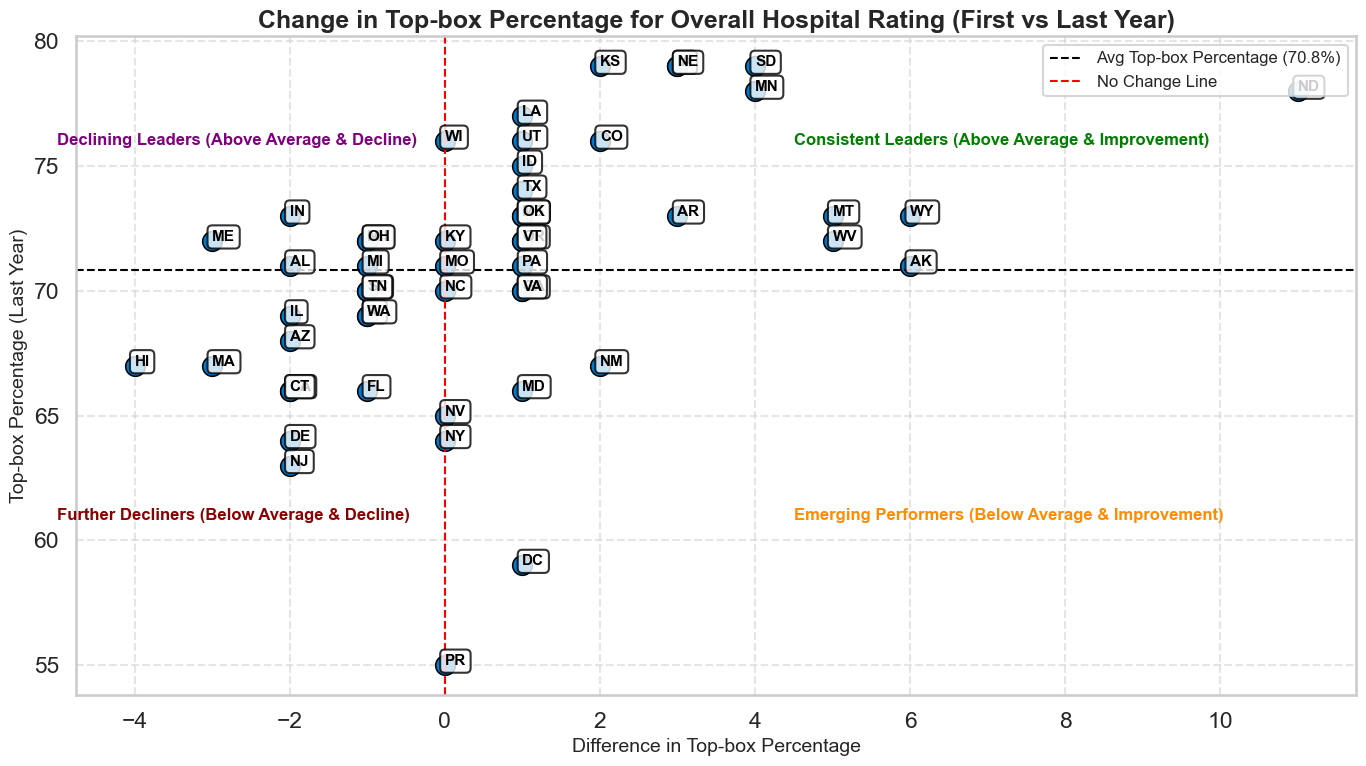

In [29]:
overall_rating_data = hcahps_data[hcahps_data['Measure'] == 'Overall Hospital Rating'][['Year', 'State', 'Top-box Percentage']]
first_year_data = overall_rating_data.sort_values('Year').groupby('State').first().reset_index()
last_year_data = overall_rating_data.sort_values('Year').groupby('State').last().reset_index()
comparison_data = first_year_data.merge(last_year_data, on='State', suffixes=('_first', '_last'))
comparison_data['Difference'] = comparison_data['Top-box Percentage_last'] - comparison_data['Top-box Percentage_first']

plt.figure(figsize=(14, 8))
sns.scatterplot(x='Difference', y='Top-box Percentage_last', data=comparison_data,
                color='#007acc', s=200, edgecolor='black')
avg_last_year = comparison_data['Top-box Percentage_last'].mean()
plt.axhline(y=avg_last_year, color='black', linestyle='--', linewidth=1.5,
            label=f'Avg Top-box Percentage ({avg_last_year:.1f}%)')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label='No Change Line')
plt.text(-5, avg_last_year + 5, 'Declining Leaders (Above Average & Decline)', fontsize=12, color='purple', weight='bold')
plt.text(-5, avg_last_year - 10, 'Further Decliners (Below Average & Decline)', fontsize=12, color='darkred', weight='bold')
plt.text(4.5, avg_last_year + 5, 'Consistent Leaders (Above Average & Improvement)', fontsize=12, color='green', weight='bold')
plt.text(4.5, avg_last_year - 10, 'Emerging Performers (Below Average & Improvement)', fontsize=12, color='darkorange', weight='bold')
for _, row in comparison_data.iterrows():
    plt.text(x=row['Difference'], y=row['Top-box Percentage_last'], s=row['State'], 
             fontdict=dict(color='black', size=11, weight='bold'),
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3', alpha=0.8))
plt.title('Change in Top-box Percentage for Overall Hospital Rating (First vs Last Year)', fontsize=18, weight='bold')
plt.xlabel('Difference in Top-box Percentage', fontsize=14)
plt.ylabel('Top-box Percentage (Last Year)', fontsize=14)
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.legend(loc='upper right', frameon=True, fontsize=12)
plt.tight_layout()
plt.show()

- **Declining Leaders:** States like **Wisconsin** and **Indiana** had above-average initial scores but declined over time.  
- **Consistent Leaders:** States such as **Wyoming**, **Montana**, and **Alaska** maintained both high scores and improvements.  
- **Further Decliners:** States like **Puerto Rico** and **Hawaii** had below-average scores and experienced further declines.  
- **Emerging Performers:** **New Mexico** and **Maryland** showed improvements despite starting below the average.  
- The plot highlights state-level variations in both performance trends and recovery efforts post-COVID.


---
<a id="modeling"></a>
## 5. Advanced Modeling & Statistical Analysis


<a id="modeling-objective"></a>
### 5.1 Modeling Objective & Approach

- **Purpose**: Identify top drivers of *Overall Hospital Rating* (which measures matter most?).  
- **Models**: LassoCV, RidgeCV, ElasticNetCV with 5-fold cross-validation.  
- **Evaluation**: Metrics include RMSE and R², with cross-validation.

<a id="data-prep"></a>
### 5.2 Data Preparation & Feature Engineering
- Pivoted data to create a wide-format dataset where each measure is a feature.
- Standardized numerical features.


In [30]:
# Filter relevant columns and add a COVID indicator (1 for 2021 & 2022)
model_data = hcahps_data[['Year', 'State', 'State Name', 'Measure', 'Top-box Percentage']].copy()
model_data['covid_19'] = model_data['Year'].apply(lambda x: 1 if x in [2021, 2022] else 0)

# Pivot so that each measure becomes its own column
model_wide = model_data.pivot_table(
    index=['Year', 'State', 'State Name', 'covid_19'],
    columns='Measure',
    values='Top-box Percentage'
).reset_index()

# Ensure target variable exists and drop rows with missing Overall Hospital Rating
if 'Overall Hospital Rating' not in model_wide.columns:
    raise ValueError("Missing 'Overall Hospital Rating' column.")
model_wide = model_wide.dropna(subset=['Overall Hospital Rating'])

# Optionally drop a highly correlated feature if present
if 'Willingness to Recommend the Hospital' in model_wide.columns:
    corr_val = model_wide['Overall Hospital Rating'].corr(model_wide['Willingness to Recommend the Hospital'])
    print("Correlation between Overall Hospital Rating and Willingness to Recommend:", corr_val)
    model_wide = model_wide.drop(columns=['Willingness to Recommend the Hospital'])

# Standardize column names and drop unneeded columns for modeling
model_wide.columns = model_wide.columns.str.lower().str.replace(' ', '_')
transformed_data = model_wide.drop(columns=['year', 'state', 'state_name'])
display(transformed_data.head())

Correlation between Overall Hospital Rating and Willingness to Recommend: 0.9243601506671556


Measure,covid_19,care_transition,cleanliness_of_hospital_environment,communication_about_medicines,communication_with_doctors,communication_with_nurses,discharge_information,overall_hospital_rating,quietness_of_hospital_environment,responsiveness_of_hospital_staff
0,0,49.0,70.0,64.0,75.0,74.0,85.0,65.0,58.0,68.0
1,0,53.0,72.0,67.0,86.0,81.0,85.0,73.0,71.0,69.0
2,0,50.0,74.0,65.0,84.0,80.0,83.0,70.0,67.0,69.0
3,0,50.0,70.0,64.0,78.0,77.0,87.0,70.0,58.0,66.0
4,0,49.0,70.0,62.0,78.0,75.0,84.0,68.0,52.0,62.0


#### 5.2.1 Define Target & Features

In [31]:
# Define target and features
target = 'overall_hospital_rating'
features = [col for col in transformed_data.columns if col != target]

# Prepare X and y; drop rows with missing feature values
X = transformed_data[features].dropna(axis=0, how='any')
y = transformed_data.loc[X.index, target]
print("Features shape:", X.shape, "| Target shape:", y.shape)

Features shape: (509, 9) | Target shape: (509,)


#### 5.2.2 Train/Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (407, 9) (407,)
Test set: (102, 9) (102,)


#### 5.2.3 Scaling

In [33]:
# Scale numeric features (except the binary 'covid_19' indicator)
scaler_cols = [c for c in features if c != 'covid_19']
scaler = StandardScaler()
X_train[scaler_cols] = scaler.fit_transform(X_train[scaler_cols])
X_test[scaler_cols] = scaler.transform(X_test[scaler_cols])

#### 5.2.4 Multicollinearity Check: Variance Inflation Factor (VIF)

- Before finalizing our regression model, we must check for **multicollinearity** among independent variables. High multicollinearity can lead to **unstable estimates, inflated standard errors, and misleading feature importance rankings**.


In [34]:

# Define predictor variables (excluding 'covid_19' since it's a binary variable)
predictors = [
    "care_transition", "cleanliness_of_hospital_environment", "communication_about_medicines",
    "communication_with_doctors", "communication_with_nurses", "discharge_information",
    "quietness_of_hospital_environment", "responsiveness_of_hospital_staff"
]

# Ensure there are no missing values in the selected features
hcahps_clean = model_wide[predictors].dropna()

# Standardizing features for VIF calculation
scaler = StandardScaler()
scaled_features = scaler.fit_transform(hcahps_clean)

# Compute VIF scores
vif_data = pd.DataFrame()
vif_data["Feature"] = predictors
vif_data["VIF"] = [variance_inflation_factor(scaled_features, i) for i in range(scaled_features.shape[1])]

# Display VIF scores
print("Variance Inflation Factor (VIF) Scores:")
display(vif_data)


Variance Inflation Factor (VIF) Scores:


,Feature,VIF
0,care_transition,7.150688
1,cleanliness_of_hospital_environment,5.235905
2,communication_about_medicines,6.584099
3,communication_with_doctors,6.285772
4,communication_with_nurses,6.930136
5,discharge_information,2.503622
6,quietness_of_hospital_environment,3.404055
7,responsiveness_of_hospital_staff,8.323623


- **VIF < 5** → Low multicollinearity (ideal)
- **VIF between 5 and 10** → Moderate multicollinearity (acceptable but should be monitored)

<a id="model-selection"></a>
### 5.3 Model Selection & Cross-Validation

In [35]:
def evaluate_model(model, X_tr, y_tr, X_te, y_te, name=""):
    """Helper function to train a model and print evaluation metrics."""
    model.fit(X_tr, y_tr)
    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)
    rmse_tr = np.sqrt(mean_squared_error(y_tr, pred_tr))
    rmse_te = np.sqrt(mean_squared_error(y_te, pred_te))
    r2_tr = r2_score(y_tr, pred_tr)
    r2_te = r2_score(y_te, pred_te)
    print(f"\n=== {name} ===")
    print(f"Train RMSE: {rmse_tr:.3f}, R²: {r2_tr:.3f}")
    print(f"Test  RMSE: {rmse_te:.3f}, R²: {r2_te:.3f}")

# Lasso Regression
lasso = LassoCV(cv=5, random_state=42)
evaluate_model(lasso, X_train, y_train, X_test, y_test, name="Lasso")

# Elastic Net Regression
enet = ElasticNetCV(cv=5, random_state=42)
evaluate_model(enet, X_train, y_train, X_test, y_test, name="Elastic Net")

# Ridge Regression
ridge = RidgeCV(cv=5)
evaluate_model(ridge, X_train, y_train, X_test, y_test, name="Ridge")


=== Lasso ===
Train RMSE: 1.199, R²: 0.915
Test  RMSE: 0.995, R²: 0.936

=== Elastic Net ===
Train RMSE: 1.199, R²: 0.915
Test  RMSE: 0.997, R²: 0.935

=== Ridge ===
Train RMSE: 1.202, R²: 0.914
Test  RMSE: 1.007, R²: 0.934


**Performance Overview:**
All three models (Lasso, Elastic Net, Ridge) achieved very high R² scores (above 0.93 on test data), meaning they explain over 93% of the variation in the outcomes. This indicates strong predictive power across the board.

**Error Metrics:**
The RMSE (Root Mean Squared Error) measures how far off the predictions are on average. Lower RMSE values are better. On test data, Lasso had the lowest RMSE (0.995), followed by Elastic Net (0.997) and Ridge (1.007).

**Conclusion:**
While all models perform well, Lasso slightly outperforms the others on unseen data, suggesting it generalizes best. Elastic Net and Ridge are very similar in performance but just a bit behind Lasso in terms of accuracy.

<a id="residual-analysis"></a>
### 5.4 Residual Analysis & Diagnostics


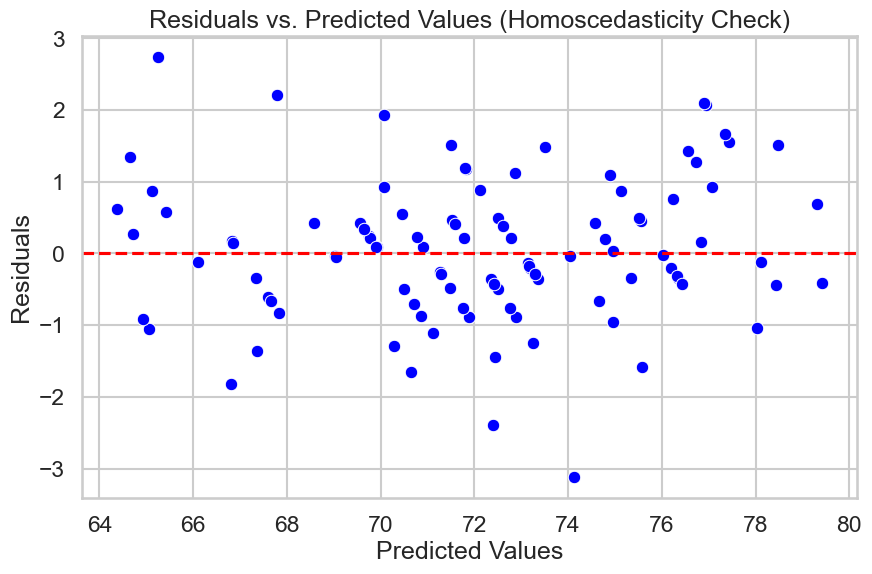

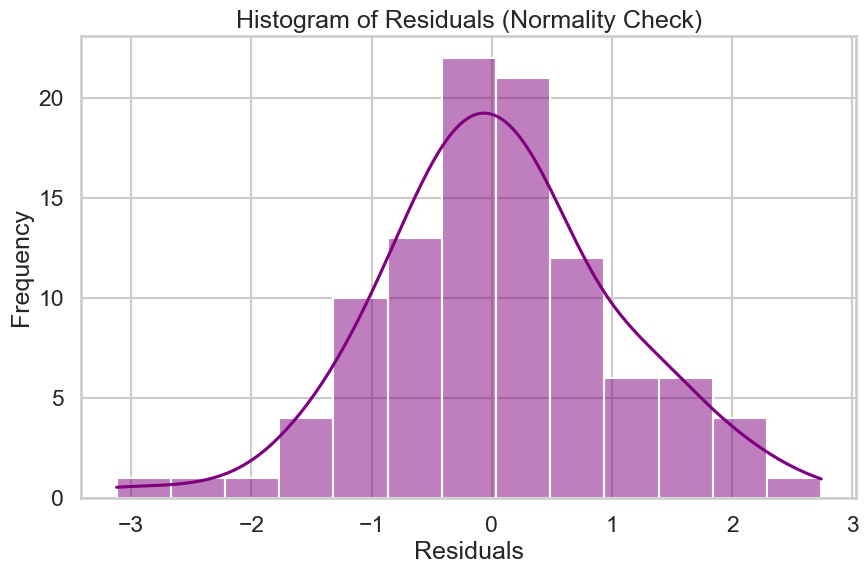

<Figure size 1000x600 with 0 Axes>

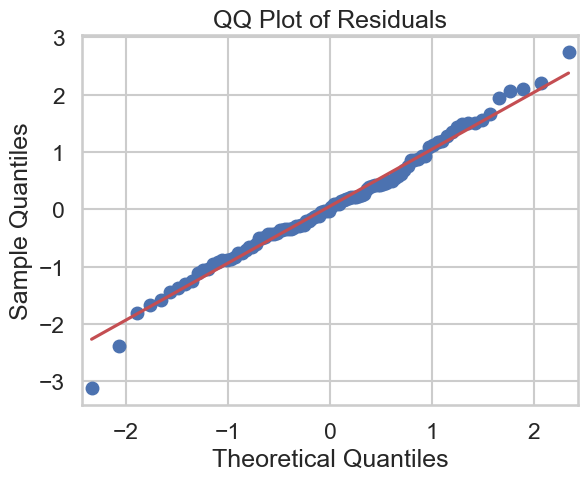

In [36]:
y_test_pred = lasso.predict(X_test)
residuals = y_test - y_test_pred

# Residuals vs. Predicted Values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_pred, y=residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values (Homoscedasticity Check)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Histogram of Residuals (Normality Check)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# QQ Plot for Residuals
plt.figure(figsize=(10, 6))
sm.qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.grid(True)
plt.show()


**Consistent Error Spread:** The residuals show a uniform spread, indicating no significant heteroscedasticity.

**Normal Residual Distribution:** The errors are roughly normally distributed, supporting the assumptions of linear regression.

<a id="feature-importance"></a>
### 5.5 Feature Importance & Interaction Analysis

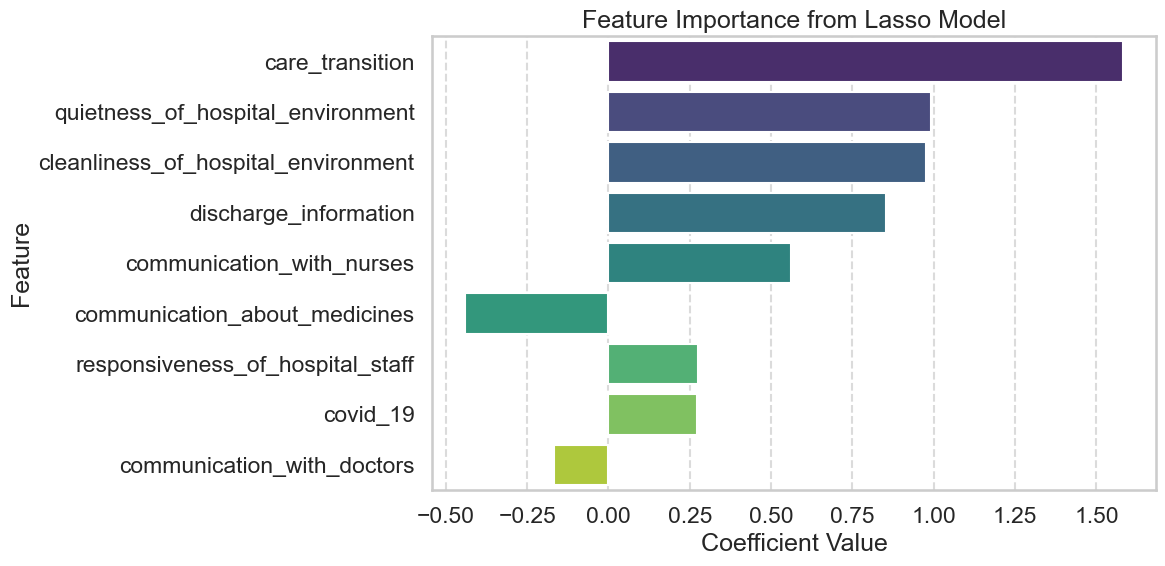

                               Feature  Coefficient
1                      care_transition     1.582540
7    quietness_of_hospital_environment     0.991708
2  cleanliness_of_hospital_environment     0.976978
6                discharge_information     0.852698
5            communication_with_nurses     0.561134
3        communication_about_medicines    -0.441338
8     responsiveness_of_hospital_staff     0.274304
0                             covid_19     0.272252
4           communication_with_doctors    -0.167461


In [37]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso.coef_
})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance from Lasso Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(feature_importance[['Feature', 'Coefficient']])

- **Strong Positive Effects:**
  - **Care Transition (1.58)**, **Quietness of Hospital Environment (0.99)**, and **Cleanliness of Hospital Environment (0.98)** are the top features positively influencing the overall rating.
  - **Discharge Information (0.85)** and **Communication with Nurses (0.56)** also contribute positively.

- **Negative Effects:**
  - **Communication about Medicines (-0.44)** has a moderate negative impact.
  - **Communication with Doctors (-0.17)** shows a small negative effect.

- **Minor Contributions:**
  - **Covid_19 (0.27)** and **Responsiveness of Hospital Staff (0.27)** have minimal influence.

- **Conclusion:**
  - The Lasso model highlights key areas in hospital experience that significantly drive the overall rating.


#### 5.5.1 SHAP Summary for deeper insights
- SHAP analysis provides additional context by capturing case-specific variability and non-linear interactions, complementing the linear interpretation of the model.


Gradient Boosting RMSE: 1.064, R²: 0.926


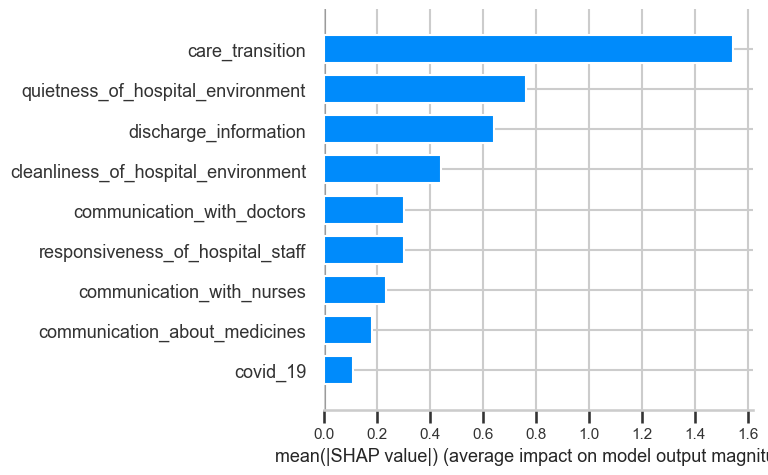

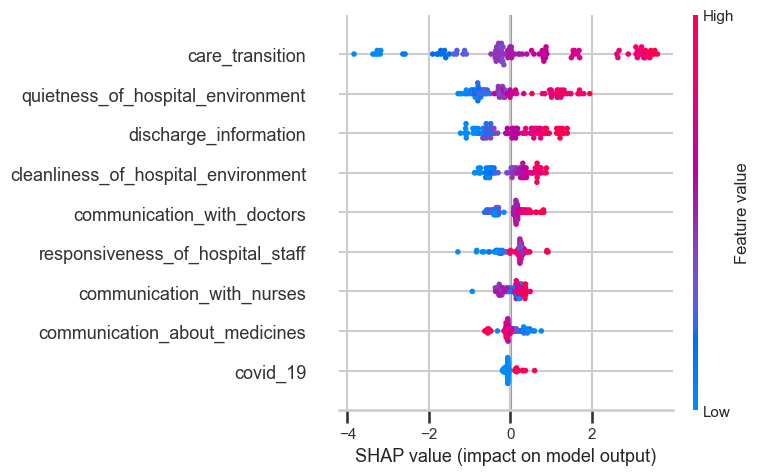

In [38]:
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X_train, y_train)
preds = gbr.predict(X_test)
rmse_gbr = np.sqrt(mean_squared_error(y_test, preds))
r2_gbr = r2_score(y_test, preds)
print(f"Gradient Boosting RMSE: {rmse_gbr:.3f}, R²: {r2_gbr:.3f}")

# SHAP explanation
explainer = shap.Explainer(gbr, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar', show=True)
shap.summary_plot(shap_values, X_test)

- **Care Transition**, **Quietness**, and **Cleanliness** exhibit high SHAP values, aligning with their strong positive coefficients in the Lasso model.  
- **Communication with Doctors** and **Communication about Medicines** have low or negative SHAP values, which also matches their small or negative coefficients.  


---
<a id="findings-and-insights"></a>
## 6. Findings & Insights

1. **Pandemic Dip**: Overall Rating declined ~2–3% around 2021–2022.  
2. **Core Drivers**: *Care Transition*, *Quietness*, *Cleanliness*, and *Discharge Info* strongly elevate satisfaction.  
3. **Communication about Medicines**: Scores lag behind other measures, especially post-COVID.  
4. **Regional Variation**: Certain states improved despite pandemic pressures, while others had steeper declines.


---
<a id="recommendations-and-next-steps"></a>
## 7. Recommendations & Next Steps

### 7.1 Recommendations
- **Strengthen Care Transitions**: Thorough discharge protocols, follow-up calls, etc.  
- **Enhance Communication**: Medication education and staff responsiveness training.  
- **Maintain Clean & Quiet Environment**: Easier high-impact factor to control.  
- **Benchmarking**: Emulate best practices from states/hospitals that thrived.

### 7.2 Next Steps
- **Investigating States with Increased Positive Responses**: Understand why certain states reported improved patient responses during COVID-19, despite national trends showing a decline.
- **Correlation Analysis**: Explore potential relationships between patient satisfaction and state-level COVID-19 data, such as case counts and death rates, over time.
- **Data Integration**: Incorporate additional data (COVID-19 cases, staff-to-patient ratios, and hospital capacity) to enhance analysis accuracy.
-  **Interactive Dashboard**:Develop a dashboard for real-time performance monitoring, helping hospital leadership respond quickly to changes.

---
<a id="references"></a>
## 8. References

- **CMS HCAHPS Data**: [Hospital Compare (Archived)](https://data.cms.gov/provider-data/archived-data/hospitals)  
- **Maven Analytics Data**: [Maven Analytics Playground](https://mavenanalytics.io/data-playground)  

